<div align="center">
<h3> CS 178: Machine Learning & Data Mining </h3>
<h1> Discussion, Week 6 </h1>
</div>

Let's start by importing some packages. We'll point out which of these imports we are using throughout the discussion, but it's handy to have them all in one place at the top of your notebook. This way, you can reload the imports without having to re-run everything else.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from IPython import display

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import zero_one_loss as J01
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

seed=1234
_=plt.set_cmap('jet')
np.random.seed(seed)

<Figure size 640x480 with 0 Axes>

# Neural Networks

Let's start with some simple data for a classification example.  We'll use two features, $(x_1,x_2)$, and two classes, positive and negative (+1 vs. -1).

In [ ]:
X, y = make_moons(n_samples=200,noise=0.2)
y[y==0] = -1                                # make {-1,1} instead of {0,1}

Xtr, Xte, ytr, yte = train_test_split(X, y)

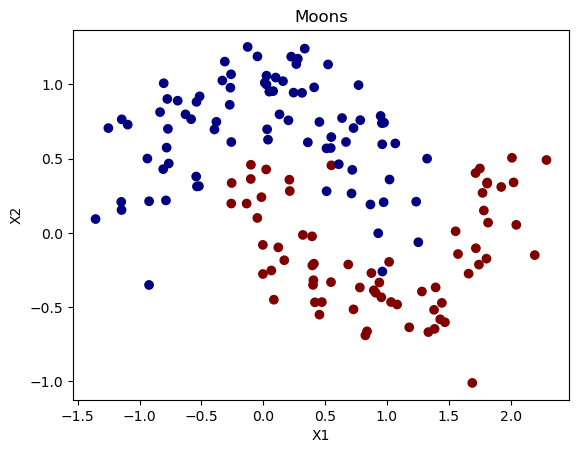

In [ ]:
fig, ax = plt.subplots()

ax.scatter(Xtr[:,0], Xtr[:,1], c=ytr);   # scatter plot, using "y" as the color
ax.set_title("Moons");
ax.set_xlabel("X1");
ax.set_ylabel("X2");

## Linear Classifier

Let's start with a simple classifier we have seen already: the logisitc regression classifier, which has a simple linear decision boundary.

In [ ]:
learner = LogisticRegression()
learner.fit(Xtr,ytr);

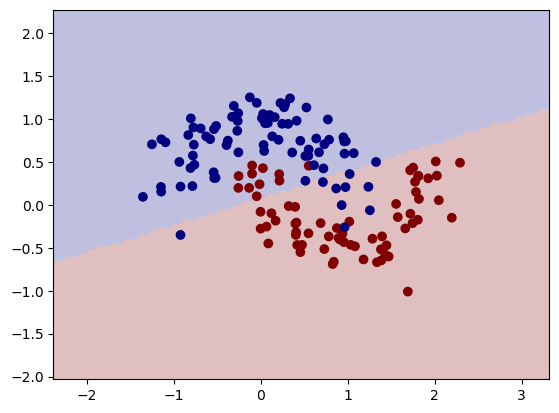

Error rate: 0.14


In [ ]:
plot_kwargs = {'cmap':'jet',
               'response_method':'predict',
               'plot_method':'pcolormesh',
               'shading':'auto',
               'alpha':0.25,
               'grid_resolution':100 }

DecisionBoundaryDisplay.from_estimator(learner, Xtr, **plot_kwargs)
plt.scatter(Xtr[:,0],Xtr[:,1], c=ytr);
plt.show()
print(f'Error rate: {np.round(J01(learner.predict(Xtr),ytr),4)}')

Well, that's not so great, since the data are not linearly separable.

### Including Feature Transforms
We know we can build a more flexible classifier by incorporating additional features, even artificially created features such as polynomial transforms of our existing features.  Let's see how that could work:

In [ ]:
# First, build a polynomial transform object
poly = PolynomialFeatures(degree=3)
poly.fit(Xtr)

# Create our new data matrix
Xtr3 = poly.transform(Xtr)

# Fit a linear model to the new data matrix & check the error rate:
learner3 = LogisticRegression()
learner3.fit(Xtr3,ytr);
print(f'Error rate: {np.round(J01(learner3.predict(Xtr3),ytr),4)}')

Error rate: 0.0533


That's a lot better!  But how can we visualize its decision boundary?

There are a lot of ways to accomplish this, but a nice "scikit" way is to define a pipeline:

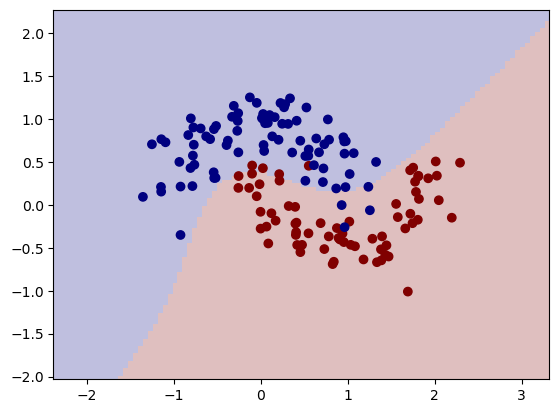

Error rate: 0.0533


In [ ]:
from sklearn.pipeline import Pipeline
learner3 = Pipeline([
              ("poly",PolynomialFeatures(degree=3, include_bias=False)),
              ("logreg", LogisticRegression())
            ])

learner3.fit(Xtr,ytr);
DecisionBoundaryDisplay.from_estimator(learner3, Xtr, **plot_kwargs)
plt.scatter(Xtr[:,0],Xtr[:,1], c=ytr);
plt.show()
print(f'Error rate: {np.round(J01(learner3.predict(Xtr),ytr),4)}')

Notice that we have asked ``scikit`` to do what you did manually in previous homework: to first transform the features, then make a prediction.  The ``Pipeline`` object just implements a simple process -- when you ``fit`` a pipeline, it sequentially calls ``fit`` on each of its members in order, then calls ``transform`` on the training data before passing the output to the next member.  Then, when you call ``predict``, it sequentially calls ``transform`` on each member, finally calling ``predict`` on the last component.  You can easily place other transforms, such as ``StandardScaler``, in this pipeline as well.

This way, the 2D visualization (``DecisionBoundaryDisplay``) knows how to convert each 2D input point into the desired, 8-dimensional

We can see that the resulting decision boundary is the solution to
$$ \theta_0 \ + \ \theta_1 x_1 + \theta_2 x_2 \ + \  \theta_3 x_1^2 + \theta_4 x_1 x_2 + \theta_5 x_2^2 \ + \ \theta_6 x_1^3 + \theta_7 x_1^2 x_2 + \theta_8 x_1 x_2^2 + \theta_{9} x_2^3 \quad = \quad 0$$
i.e., a linear decision boundary in an 8-dimensional feature space defined by powers of $x_1,x_2$.

What if we have data that is even more complicated? We can surely increase the degree of our polynomial features and thus the dimensionality of our feature space.
However, as we increase the this degree, this will also lead to an exponential increase in the number of parameters $\theta$ we need to learn, which quickly becomes infeasable, especially if we have many features to begin with. MNIST, for example, already has 784 features to begin with.
Is there a way to learn a 'useful' set of features, without having to design them manually, avoiding this pitfall? The answer is yes and the solution is neural networks as we will see shortly.

---


# (Stochastic) Gradient Descent

Many different techniques are really the same learner (for example, a linear classifier) combined with a different choice of loss.
Logisitc Regression, for example, can also be formulated using the negative log-likelihood loss, which allows us to fit parameters with Gradient Descent.

We will use ``SGDClassifier`` https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html, which only requires the selection of an appropriate loss. Let's take a look in code:

### "Logisitic Regression" Linear Classifier

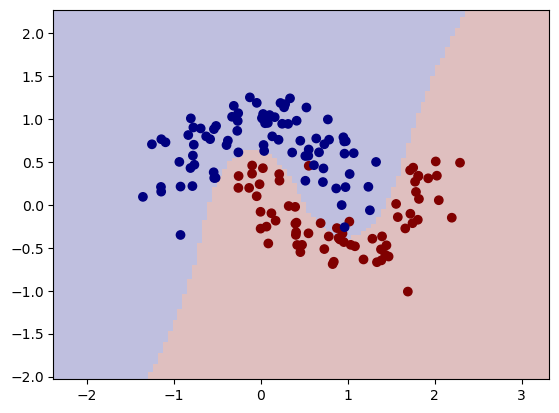

Error rate: 0.0333


In [ ]:
# "SGDClassifier" is a generic linear classifier trained using Stochastic Gradient Descent on some loss:

logreg_model = SGDClassifier(loss='log_loss')  # "log_loss" = logistic negative log-likelihood = logistic regression
learner = Pipeline([
              ("poly",PolynomialFeatures(degree=3, include_bias=False)),
              ("logreg", logreg_model)
            ])

learner.fit(Xtr,ytr);
DecisionBoundaryDisplay.from_estimator(learner, Xtr, **plot_kwargs)
plt.scatter(Xtr[:,0],Xtr[:,1], c=ytr);
plt.show()
print(f'Error rate: {np.round(J01(learner.predict(Xtr),ytr),4)}')

---

Let's take a look at Neural Networks! The major difference is that we now learn our features from the data. The loss can be the same we used in logistic regression.
As seen in this example of a small neural network given in the image below, neural networks provide a (non-linear) map from the original feature space to a new feature space (not necesarrily of the same size) containing a learned representation.

<img src="./hw3_nn_v2.png" width=500 height=400 style="margin:auto"/>

In [ ]:
learner = MLPClassifier(
                # The loss is assumed to be "log-loss" (negative log-likelihood)
                # These parameters define the model "architecture" (shape, size, etc.):
                hidden_layer_sizes=(64), activation='relu',
                # This determines how much L2 regularization to apply
                alpha = 0.0,
                # These control the optimization procedure:
                solver='sgd', learning_rate='constant', learning_rate_init=0.001, batch_size=16,
                max_iter=200, n_iter_no_change=200,
                # This allows reproducibility across runs:
                random_state=seed
            )

learner.fit(Xtr,ytr);

/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


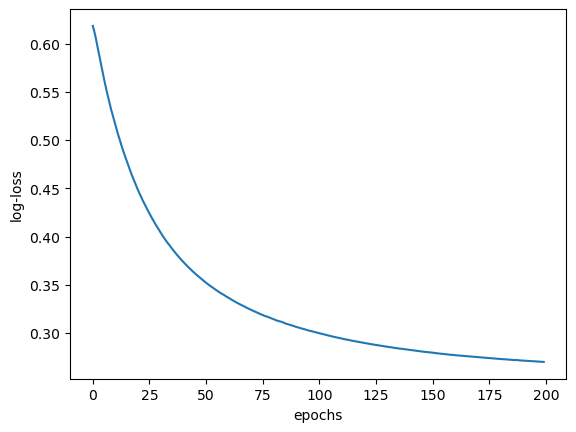

In [ ]:
plt.plot(learner.loss_curve_); plt.ylabel('log-loss'); plt.xlabel('epochs');

Is it done?  It's always hard to tell...

In [ ]:
learner.max_iter = 2000; learner.n_iter_no_change=2000;
learner.fit(Xtr,ytr);

/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


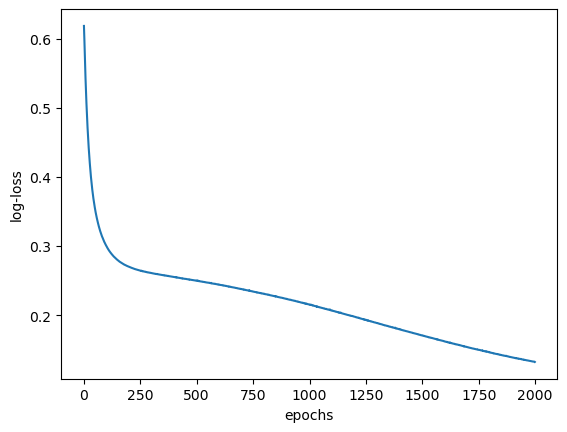

In [ ]:
plt.plot(learner.loss_curve_); plt.ylabel('log-loss'); plt.xlabel('epochs');

Nope! Definitely not done.  Maybe we should try a higher learning rate (step size)?

In [ ]:
learner.max_iter = 2000; learner.n_iter_no_change=2000;
learner.learning_rate_init=0.01
learner.fit(Xtr,ytr);

/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


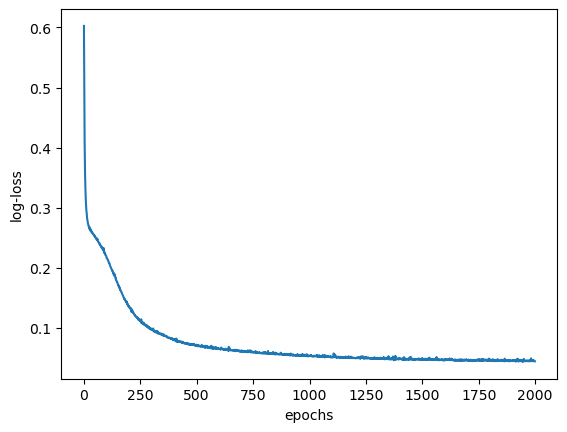

In [ ]:
plt.plot(learner.loss_curve_); plt.ylabel('log-loss'); plt.xlabel('epochs');

What does our current classifier look like?

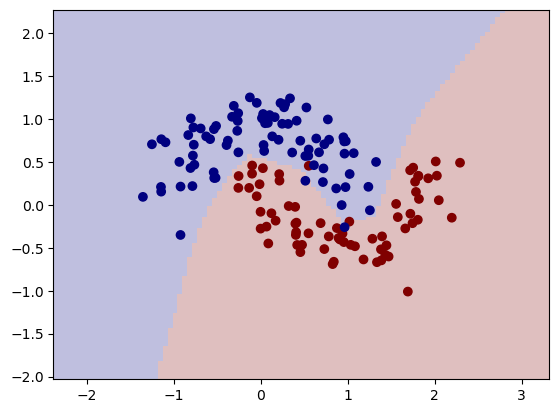

Error rate: 0.0267


In [ ]:
DecisionBoundaryDisplay.from_estimator(learner, Xtr, **plot_kwargs)
plt.scatter(Xtr[:,0],Xtr[:,1], c=ytr);
plt.show()
print(f'Error rate: {np.round(J01(learner.predict(Xtr),ytr),4)}')

**NOTE**: If you want to continue training more, after your optimization has stopped, you can use the ``warm_start=True`` flag.  By default, the model is re-initialized each time you call ``fit``, but with ``warm_start`` it will begin optimization from the current parameter values.  (This allows you not to lose your model's progress if you decide you want to change the learning rate or add regularization after you have already done some training.)

---


## Complexity and Neural Networks

The number of layers and hidden nodes determines the representational power of the neural network.  For a two-layer NN, for example, the more nodes in the hidden layer, the more "trainable features" we are providing to the output layer's linear classifier; with more features, we increase its ability to fit (and overfit!).

For example, if we greatly reduce the number of hidden nodes, we will tend to learn a simpler decision function:

In [ ]:
learner = MLPClassifier(
                hidden_layer_sizes=(4), activation='relu',
                alpha = 0.0,
                solver='sgd', learning_rate='constant', learning_rate_init=0.001, batch_size=16,
                max_iter=2000, n_iter_no_change=2000,
                random_state=seed
            )

learner.fit(Xtr,ytr);

/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


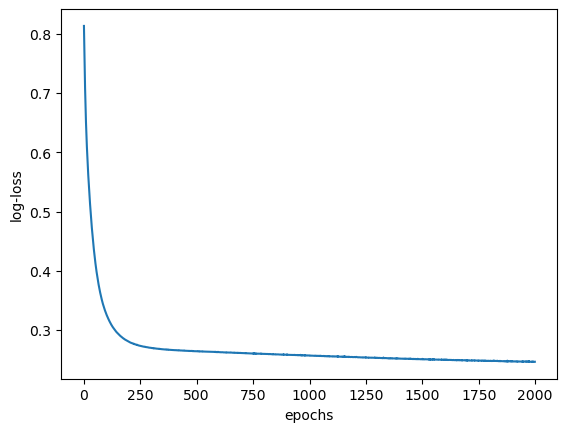

In [ ]:
plt.plot(learner.loss_curve_); plt.ylabel('log-loss'); plt.xlabel('epochs');

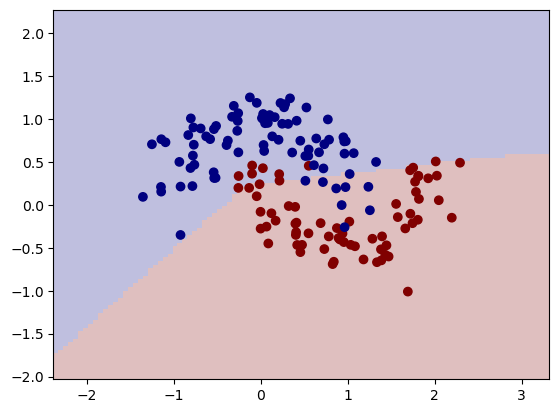

Error rate: 0.12


In [ ]:
DecisionBoundaryDisplay.from_estimator(learner, Xtr, **plot_kwargs)
plt.scatter(Xtr[:,0],Xtr[:,1], c=ytr);
plt.show()
print(f'Error rate: {np.round(J01(learner.predict(Xtr),ytr),4)}')

## Overfitting and Learning Curves

Neural networks are very powerful feature learners - so we have to be careful we don't overfit to the data, especially when only a small number of features is available.

In [ ]:
np.random.seed(0)
X, y = make_moons(n_samples=2000,noise=0.4)
Xtr, Xte, ytr, yte = train_test_split(X, y)

/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


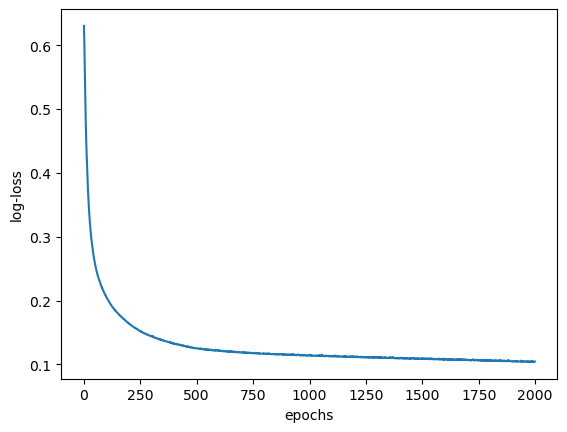

In [ ]:
learner = MLPClassifier(
                # The loss is assumed to be "log-loss" (negative log-likelihood)
                # These parameters define the model "architecture" (shape, size, etc.):
                hidden_layer_sizes=(64), activation='relu',
                # This determines how much L2 regularization to apply
                alpha = 0.0,
                # These control the optimization procedure:
                solver='sgd', learning_rate='constant', learning_rate_init=0.01, batch_size=32,
                max_iter=2000, n_iter_no_change=2000,
                # This allows reproducibility across runs:
                random_state=seed
            )

m_use = 50
learner.fit(Xtr[:m_use,:],ytr[:m_use]);
plt.plot(learner.loss_curve_); plt.ylabel('log-loss'); plt.xlabel('epochs');

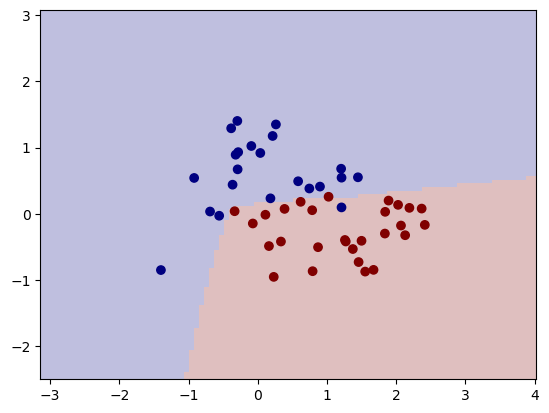

Error rate (train): 0.04
Error rate (test): 0.184


In [ ]:
DecisionBoundaryDisplay.from_estimator(learner, Xtr, **plot_kwargs)
plt.scatter(Xtr[:m_use,0],Xtr[:m_use,1], c=ytr[:m_use]);
plt.show()
print(f'Error rate (train): {np.round(J01(learner.predict(Xtr[:m_use,:]),ytr[:m_use]),4)}')
print(f'Error rate (test): {np.round(J01(learner.predict(Xte),yte),4)}')

We can see that here the neural network failed to learn the underlying structure of the dataset. To avoid this we can employ many of the methods from the lecture like regularization, or simply increasing the amount of data available to the network.

/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


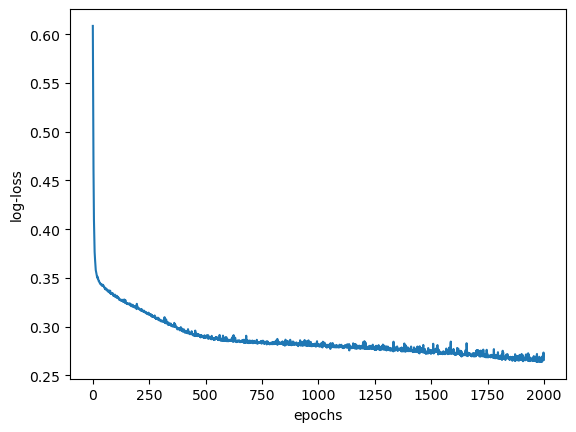

In [ ]:
m_use = 200
learner.fit(Xtr[:m_use,:],ytr[:m_use]);
plt.plot(learner.loss_curve_); plt.ylabel('log-loss'); plt.xlabel('epochs');

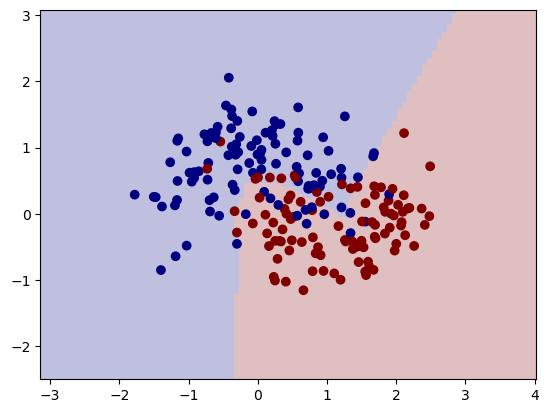

Error rate (train): 0.14
Error rate (test): 0.146


In [ ]:
DecisionBoundaryDisplay.from_estimator(learner, Xtr, **plot_kwargs)
plt.scatter(Xtr[:m_use,0],Xtr[:m_use,1], c=ytr[:m_use]);
plt.show()
print(f'Error rate (train): {np.round(J01(learner.predict(Xtr[:m_use,:]),ytr[:m_use]),4)}')
print(f'Error rate (test): {np.round(J01(learner.predict(Xte),yte),4)}')

Now the train and test error are closer together again, we have learned the underlying structure much better and observe less overfitting!

Bonus plot with even more data (takes a while to compute)

/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


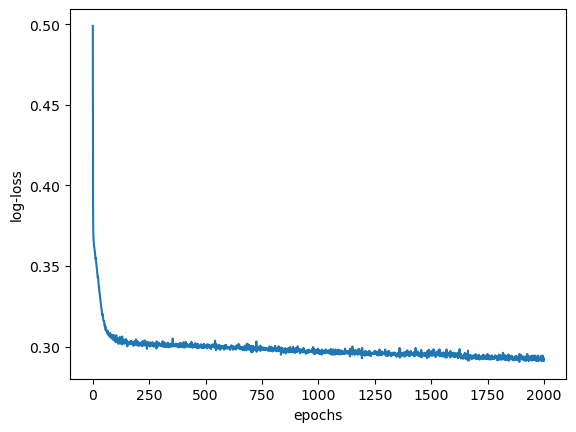

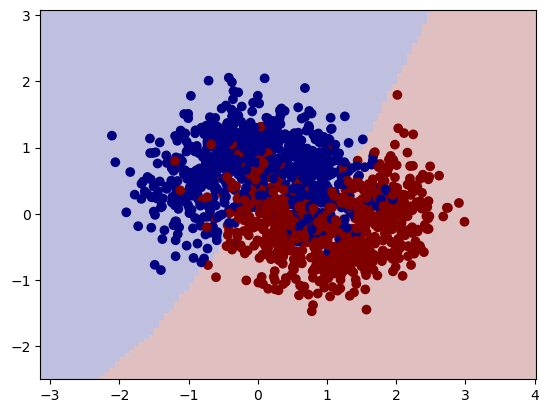

Error rate (train): 0.1267
Error rate (test): 0.142


In [ ]:
m_use = 2000
learner.fit(Xtr[:m_use,:],ytr[:m_use]);
plt.plot(learner.loss_curve_); plt.ylabel('log-loss'); plt.xlabel('epochs');
DecisionBoundaryDisplay.from_estimator(learner, Xtr, **plot_kwargs)
plt.scatter(Xtr[:m_use,0],Xtr[:m_use,1], c=ytr[:m_use]);
plt.show()
print(f'Error rate (train): {np.round(J01(learner.predict(Xtr[:m_use,:]),ytr[:m_use]),4)}')
print(f'Error rate (test): {np.round(J01(learner.predict(Xte),yte),4)}')